In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from pprint import pprint

from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

# Annahmen

- Modell symmetrisch (Encoder u. Decoder)
- Anzahl an Knoten in den Hidden Layern steigt/sinkt linear

# Daten vorverarbeiten

In [2]:
df = pd.read_pickle("Daten/data.pkl")
df_ohne_id = df.drop(columns=["id"])
feature_names = df_ohne_id.columns
feature_cnt = df_ohne_id.shape[1]

random_state = 21

x_train, x_test, y_train, y_test = train_test_split(df_ohne_id, np.zeros(shape=df_ohne_id.shape[0]), test_size=0.2, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=random_state)

del y_train
del y_val
del y_test

scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# Funktion um Knotenanzahl für Hidden Layers zu berechnen (linear)

In [3]:
def get_nr_units_for_hidden_layers(n_hidden_layers, first_layer_nodes, last_layer_nodes):
    if n_hidden_layers <= 0:
        return []
    
    n_layers = n_hidden_layers + 2
    layers = []
    nodes_increment = (last_layer_nodes - first_layer_nodes) / (n_layers - 1)
    nodes = first_layer_nodes
    
    for i in range(1, n_layers-1):
        nodes = nodes + nodes_increment
        layers.append(np.ceil(nodes))
    
    return layers


# Bsp.: Input 1 Knoten, Output 6 Knote, Man hätte gerne 2 Hidden Layers
get_nr_units_for_hidden_layers(2, 1, 6)

[3, 5]

# Modell definieren

In [94]:
# Basis-Modell
class Autoencoder(Model):
    def __init__(self, feature_cnt):
        super(Autoencoder, self).__init__()
        self.feature_cnt = feature_cnt
        self.encoder = keras.Sequential([
#             layers.Dropout(0.1)
        ], name="encoder")
        self.decoder = keras.Sequential([
#             layers.Dropout(0.1)
        ], name="decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

# Funktion um Modell zu erstellen mit Parameter zur Einstellung der Anzahl an Hidden Layers
def create_model(feature_cnt, nr_hidden_layers, nr_units_middle_layer):
    model = Autoencoder(feature_cnt)
    
    # Calculate number of units for each hidden layer (linear function)
    nr_encoder_units = get_nr_units_for_hidden_layers(nr_hidden_layers, feature_cnt, 4)
    nr_decoder_units = nr_encoder_units[::-1]
        
    for enc_units, dec_units in zip(nr_encoder_units, nr_decoder_units):
        # Add one hidden layer
        model.encoder.add(layers.Dense(enc_units, activation='relu'))
#         model.encoder.add(layers.Dropout(0.1))
        model.decoder.add(layers.Dense(dec_units, activation='relu'))
#         model.decoder.add(layers.Dropout(0.1))

    # Add middle and output layer 
    model.encoder.add(layers.Dense(nr_units_middle_layer, activation='sigmoid'))
    model.decoder.add(layers.Dense(model.feature_cnt, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    model.build(input_shape=(None, feature_cnt))
    
    return model


model = KerasRegressor(build_fn=create_model, verbose=0, feature_cnt=14)

<ipython-input-94-e610b3c2b451>:45: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0, feature_cnt=14)


# Hyperparameter definieren

In [95]:
param_grid = {
    "nr_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "nr_units_middle_layer": [2, 4],
    "epochs": [20], # Grund: siehe Diagramm von https://stackoverflow.com/questions/49823192/autoencoder-gridsearch-hyperparameter-tuning-keras
}


pg = ParameterGrid(param_grid)


print(f"Number of combinations: {len(pg)}\n")
pprint(list(pg))

Number of combinations: 26

[{'nr_hidden_layers': 0, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 0, 'nr_units_middle_layer': 4},
 {'nr_hidden_layers': 1, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 1, 'nr_units_middle_layer': 4},
 {'nr_hidden_layers': 2, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 2, 'nr_units_middle_layer': 4},
 {'nr_hidden_layers': 3, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 3, 'nr_units_middle_layer': 4},
 {'nr_hidden_layers': 4, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 4, 'nr_units_middle_layer': 4},
 {'nr_hidden_layers': 5, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 5, 'nr_units_middle_layer': 4},
 {'nr_hidden_layers': 6, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 6, 'nr_units_middle_layer': 4},
 {'nr_hidden_layers': 7, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 7, 'nr_units_middle_layer': 4},
 {'nr_hidden_layers': 8, 'nr_units_middle_layer': 2},
 {'nr_hidden_layers': 8, 'nr_units_middle_layer': 4},


# GridSearch starten

In [96]:
%%time
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, return_train_score=True, scoring="neg_root_mean_squared_error") # Negativer Score, weil GridSearchCV versucht die Funktion zu maximieren

grid_result = grid.fit(x_train_scaled, x_train_scaled,
                       batch_size=512,
                       validation_data=(x_val_scaled, x_val_scaled),
                       shuffle=True,
                      )

Wall time: 3min 23s


# Ergebnisse ausgeben

## Beste n Kandidaten anzeigen

In [97]:
def get_n_best_candidates(grid_result, n):
    means = np.array(grid_result.cv_results_['mean_test_score'])
    params = np.array(grid_result.cv_results_['params'])
    idx = (-means).argsort()[:n]
    return {
        "means": list(means[idx]),
        "params": list(params[idx])
    }

In [98]:
n = 5
best_candidates = get_n_best_candidates(grid_result, n)

print(f"Best {n} candidates:\n")
for mean, param in zip(best_candidates["means"], best_candidates["params"]):
    print(f"Score: {-mean:.4f} | {param}")

Best 5 candidates:

Score: 0.0907 | {'nr_hidden_layers': 3, 'nr_units_middle_layer': 4}
Score: 0.0968 | {'nr_hidden_layers': 6, 'nr_units_middle_layer': 4}
Score: 0.0970 | {'nr_hidden_layers': 6, 'nr_units_middle_layer': 2}
Score: 0.0970 | {'nr_hidden_layers': 10, 'nr_units_middle_layer': 4}
Score: 0.0970 | {'nr_hidden_layers': 10, 'nr_units_middle_layer': 2}


## Alle Kombinationen anzeigen

In [99]:
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']

print("All candidates:\n")
for mean, param in zip(means, params):
    print(f"Score: {-mean:.4f} | {param}")

All candidates:

Score: 0.1365 | {'nr_hidden_layers': 0, 'nr_units_middle_layer': 2}
Score: 0.1340 | {'nr_hidden_layers': 0, 'nr_units_middle_layer': 4}
Score: 0.1239 | {'nr_hidden_layers': 1, 'nr_units_middle_layer': 2}
Score: 0.1025 | {'nr_hidden_layers': 1, 'nr_units_middle_layer': 4}
Score: 0.1053 | {'nr_hidden_layers': 2, 'nr_units_middle_layer': 2}
Score: 0.0989 | {'nr_hidden_layers': 2, 'nr_units_middle_layer': 4}
Score: 0.0987 | {'nr_hidden_layers': 3, 'nr_units_middle_layer': 2}
Score: 0.0907 | {'nr_hidden_layers': 3, 'nr_units_middle_layer': 4}
Score: 0.0985 | {'nr_hidden_layers': 4, 'nr_units_middle_layer': 2}
Score: 0.1032 | {'nr_hidden_layers': 4, 'nr_units_middle_layer': 4}
Score: 0.0996 | {'nr_hidden_layers': 5, 'nr_units_middle_layer': 2}
Score: 0.1003 | {'nr_hidden_layers': 5, 'nr_units_middle_layer': 4}
Score: 0.0970 | {'nr_hidden_layers': 6, 'nr_units_middle_layer': 2}
Score: 0.0968 | {'nr_hidden_layers': 6, 'nr_units_middle_layer': 4}
Score: 0.0987 | {'nr_hidden_lay

# Ergebnisse visualisieren

## Datenstruktur zur Vorbereitung erstellen

In [100]:
df = pd.DataFrame({
    'nr_hidden_layers': grid_result.cv_results_["param_nr_hidden_layers"],
    'nr_units_middle_layer': grid_result.cv_results_["param_nr_units_middle_layer"],
    'score': -grid_result.cv_results_["mean_test_score"]
})

df_cross = df.groupby(['nr_hidden_layers', 'nr_units_middle_layer'])['score'].sum().unstack()

df_cross.head()

nr_units_middle_layer,2,4
nr_hidden_layers,,
0,0.136472,0.133987
1,0.123925,0.102501
2,0.105317,0.098940
3,0.098662,0.090683
4,0.098488,0.103212


## 3D Visualisierung

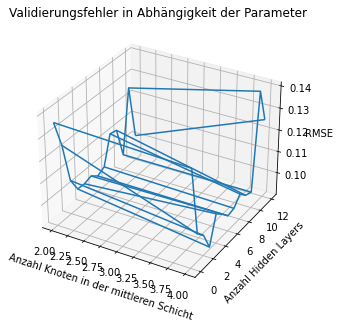

In [101]:
# %matplotlib notebook

x = df_cross.columns
y = df_cross.index
X, Y = np.meshgrid(x, y)
Z = df_cross

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(X, Y, Z)
ax.set_xlabel("Anzahl Knoten in der mittleren Schicht")
ax.set_ylabel("Anzahl Hidden Layers")
ax.set_zlabel("RMSE")
plt.title("Validierungsfehler in Abhängigkeit der Parameter")

plt.show()

## 2D Diagramme

In [102]:
grid_result.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_nr_hidden_layers', 'param_nr_units_middle_layer', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [103]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params = grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1, len(params), sharex='none', sharey='all', figsize=(20,5))
    fig.suptitle('Score pro Parameter')
    fig.text(0.04, 0.5, 'RMSE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, -y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, -y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p)

    plt.legend()
    plt.show()

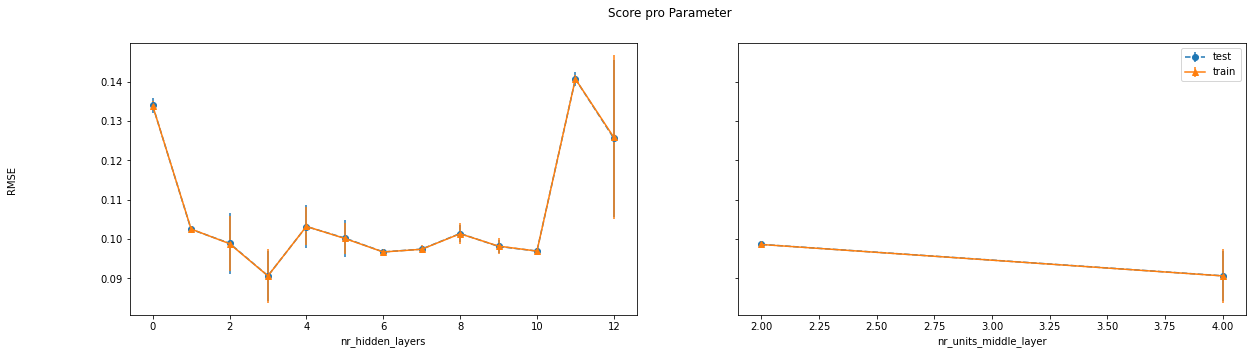

In [104]:
plot_search_results(grid_result)

In [ ]:
# TODO: Knotenanzahl in der mittleren Schicht nicht als Hyperparameter sinnvoll. Für die Optimierung, d.h. um den den
# Rekonstruktionsfehler zu minimieren, ist es immer besser mehr Knoten in der mittleren Schicht zu haben.
# Dadurch lernt das Modell aber auch weniger. Extrembsp. Anz. Middle Layer = Input = Output führt zu Kopieren der Informationen